# Introduction

### In this notebook we are going to try explore the data we have and going try answer questions like:

* How's the trend of border crossings looks?
* Is there coherent seasonality?
* Is there unexpected sharp spikes or drops and why?
* Can we forecast the entries in near future?
* Which border and state is busier than other/s?
* What are the most common entry type?
* Do presidents have observable impact on total entries in their terms?
* And much more!

**If you liked this kernel feel free to upvote and leave feedback, thanks!**

In [1]:
# Importing neccesary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import warnings

#

import statsmodels.api as sm
from pylab import rcParams
import scipy.stats as ss
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

# Meeting the data

In [2]:
# Loading data
data = pd.read_csv('Border_Crossing_Entry_Data.csv')

In [3]:
# Looking at the shape
data.shape

(355511, 7)

In [4]:
# Checking how data looks
data.sample(5)

,Port Name,State,Port Code,Border,Date,Measure,Value
156579,Port Huron,MI,3802,US-Canada Border,12/1/2008 00:00,Pedestrians,0
287843,Ferry,WA,3013,US-Canada Border,7/1/2000 00:00,Rail Containers Full,0
125877,Sasabe,AZ,2606,US-Mexico Border,11/1/2010 00:00,Personal Vehicle Passengers,3287
196488,Walhalla,ND,3407,US-Canada Border,6/1/2006 00:00,Personal Vehicles,4028
333945,Otay Mesa,CA,2506,US-Mexico Border,6/1/1997 00:00,Bus Passengers,24501


In [5]:
# Parsing dates
data['Date'] = pd.to_datetime(data['Date'])

In [6]:
# Replacing Values with proper name
data.rename(columns={'Value': 'Total Entries'}, inplace=True)

In [7]:
# Extracting year and month data for future uses
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month

# Visualizing Entry Time Series Data

**It looks like total entries have been in declining trend between 2002 and 2012 and then there is slight increase but it's pretty much stable.**

**When we inspecting the data by eye we can see the there is some sort of seasonality with 3 discrete sharp declines:**

* First one is somewhere between 1997-1998, I'm not sure what's the reason behind it yet...
* Second one is in between 2001-2002 it's highly likely due to September 11 attacks,
* Last one is between 2008-2009, probably it's related to 2008 finance crisis.

There is some sort of seasonality effect for sure, let's inspect it in next chapter.

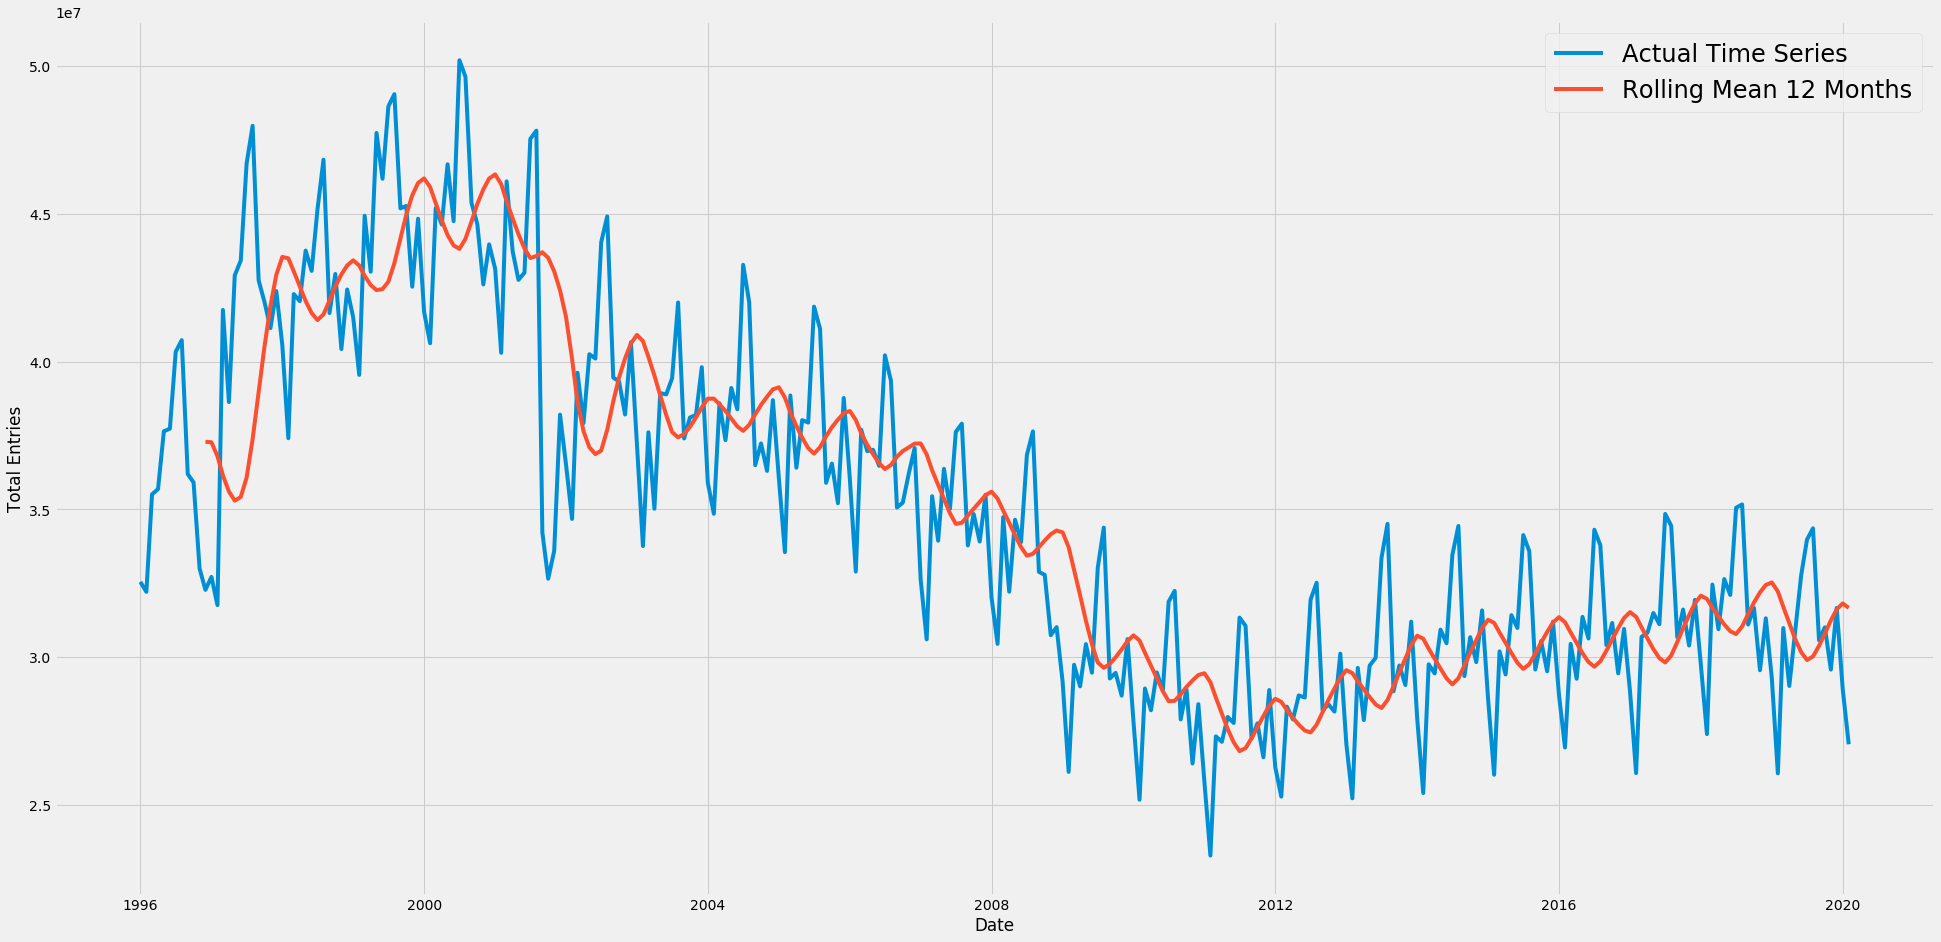

In [8]:
# Inspecting time series and rolling mean
crossing = data[['Date', 'Total Entries']].groupby('Date').sum()
tseries = data.groupby(['Date'])['Total Entries'].agg(
    ['sum']).reset_index().rename(columns={'sum': 'Total Entries'})
tseries = tseries.set_index('Date')
fig = plt.subplots(figsize=(30, 15))
g = sns.lineplot(x=tseries.index, y='Total Entries',
                 data=tseries, label="Actual Time Series")
rmean = crossing.rolling(12, win_type='triang').mean()
g = sns.lineplot(x=rmean.index, y='Total Entries',
                 data=rmean, label="Rolling Mean 12 Months")
plt.legend(fontsize='xx-large')
plt.show()

# Decomposing the time series

* **The trend chart confirms our first observations with 10 years of decline and slightlu climbing next 10 years.**


* **Seasonality is there for sure! It's clearly observable, It looks highly related to tourism and weather conditions and holidays. When we look closely we can see entries peak around Jul and then there is small jump before christmas and then sharp decline right after new years...**

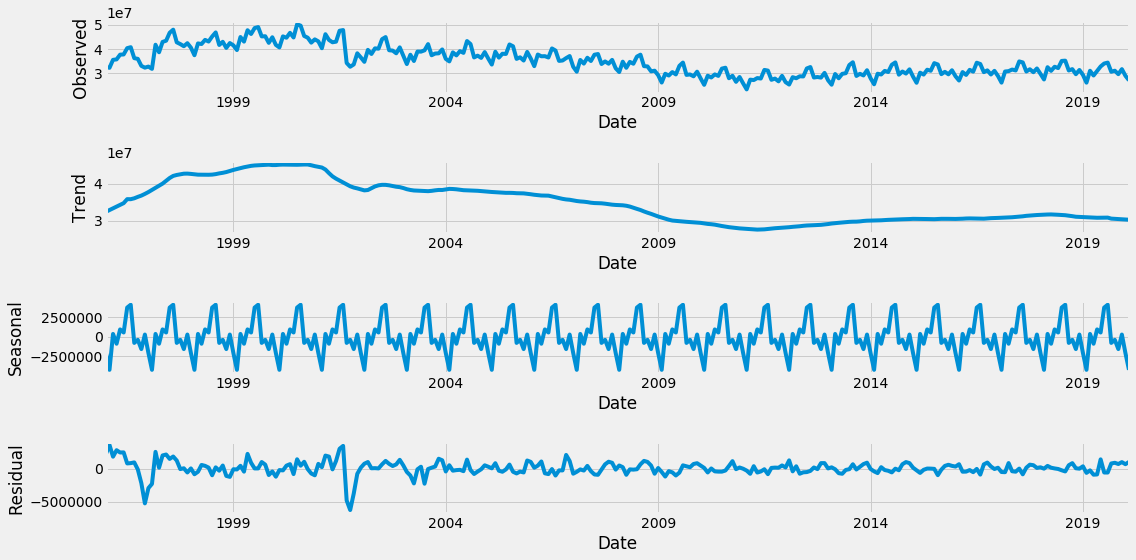

In [9]:
# Decomposing the data

decompose = sm.tsa.seasonal_decompose(
    tseries, model='additive', extrapolate_trend='freq')

# Plot
fig, axes = plt.subplots(nrows=4, figsize=(16, 8))

decompose.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')

decompose.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')

decompose.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')

decompose.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')


plt.tight_layout()
plt.show()

# Modelling

**We going to apply one of the most common forecasting methods: ARIMA(Autoregressive Integrated Moving Average)**

In [10]:
# Choosing train data
train = tseries.loc['2010':'2020']

In [11]:
# Examples for easonality, trend, and noise combinations
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12)
                for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [12]:
# Searching for paramaters
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param,
                                                 param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:4512.192055179839
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:3996.813303809917
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:3300.0574074823808
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2937.169357752538
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:3329.0458419700235
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:3270.9060404200377
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:2961.6711243584923
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:2896.0657477970703
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:4390.328746817695
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:3934.1300666138814
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:3239.980339117364
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:2871.2452829093363
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:3996.490211322106
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:3925.900124903381
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:2934.275126018643
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:2860.478184235688
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:3868.756942042226
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:3415.697196367057
ARI

In [13]:
# Fitting the model
mod = sm.tsa.statespace.SARIMAX(train,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0088      0.196      0.045      0.964      -0.376       0.394
ma.L1         -0.5945      0.123     -4.843      0.000      -0.835      -0.354
ar.S.L12      -0.1633      0.183     -0.890      0.373      -0.523       0.196
ma.S.L12       0.0030      0.206      0.014      0.989      -0.402       0.408
sigma2      4.103e+11   4.24e-13   9.67e+23      0.000     4.1e+11     4.1e+11


# Validating our model

**Our model looks decent, let's continue with validating our forecast.**

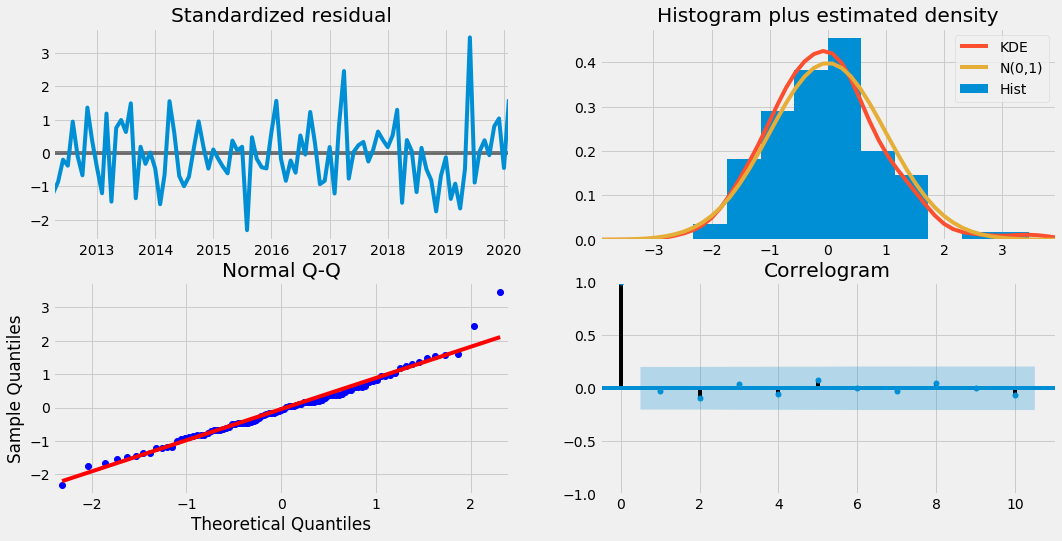

In [14]:
# Investigating the results
results.plot_diagnostics(figsize=(16, 8))
plt.show()

**Our forecasts for past 5 years align with the observed values, which is good...**

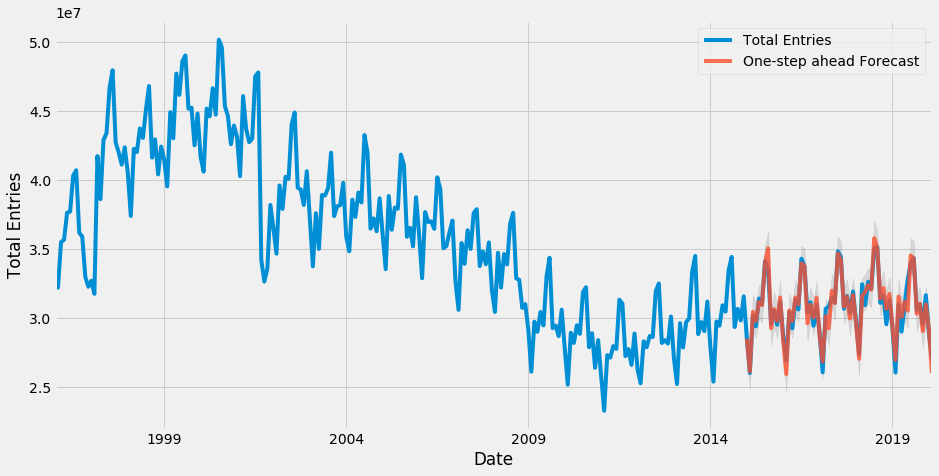

In [15]:
# Validating forecasts
pred = results.get_prediction(
    start=pd.to_datetime('2015-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = tseries['1996':].plot(label='observed')
pred.predicted_mean.plot(
    ax=ax, label='One-step ahead Forecast', alpha=.8, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.1)
ax.set_xlabel('Date')
ax.set_ylabel('Total Entries')
plt.legend()
plt.show()

# Forecasting

**Allright! Let's forecast next 60 months... Hmm... It looks our model captured the seasonality well with the slight increasing trend. I'd say our models confidence interval grows alot after 2 years so gets less confident but still looks fine!**

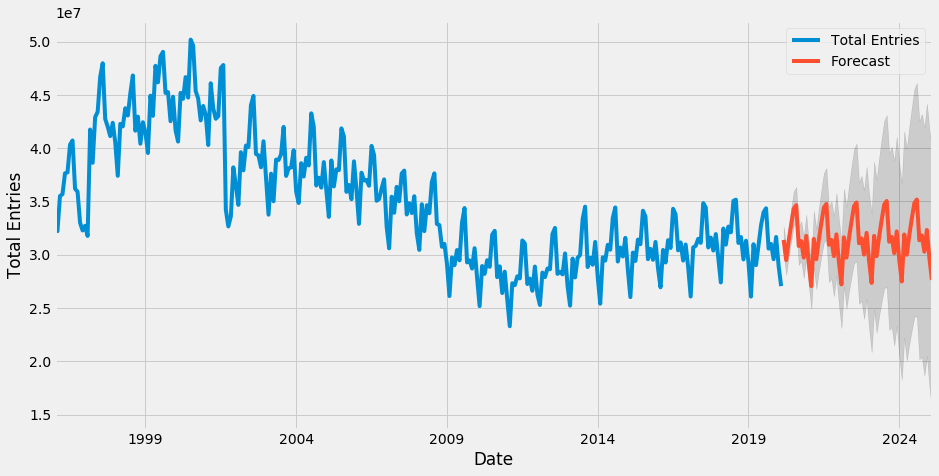

In [16]:
# Forecasting
pred_uc = results.get_forecast(steps=60)
pred_ci = pred_uc.conf_int()
ax = tseries.plot(label='Total Entries', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.15)
ax.set_xlabel('Date')
ax.set_ylabel('Total Entries')
plt.legend()
plt.show()

# Visualizing the data

**It's time to get deeper into our data and get some insights!**

# Entries by month

**We can see the seasonality effect on Canadian border much more than Mexican border, Canadian entries gets higher in summer months meanwhile Mexican entries somewhat stable...**

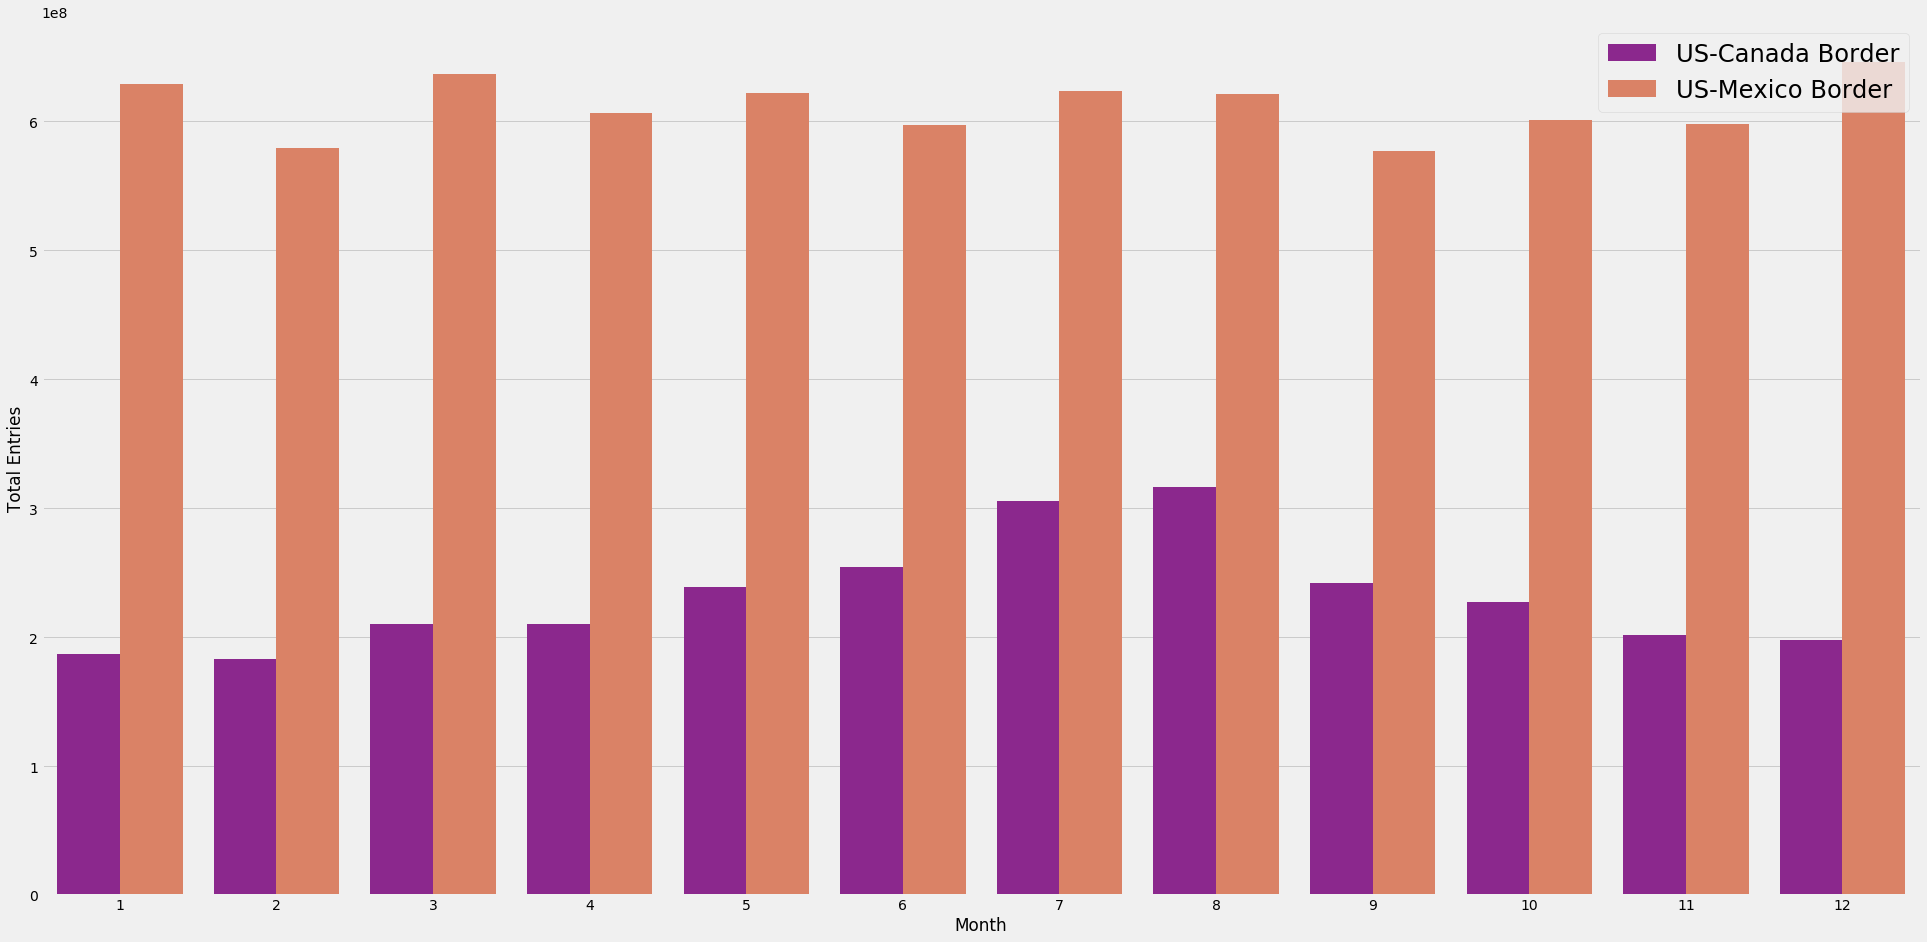

In [17]:
# Entries by month
month_data = data.groupby(['Month', 'Border'])[
    'Total Entries'].agg(['sum']).reset_index().rename(columns={'sum': 'Total Entries'})

fig = plt.subplots(figsize=(30, 15))
sns.barplot(x='Month', y='Total Entries', hue='Border',
            data=month_data, palette='plasma')
plt.legend(fontsize='xx-large')
plt.show()

# Entries by year

**Well it's clear that between 2000 and 2011 there is decreasing trend, especially for Mexican entries, meanwhile Canadian entries somewhat more stable. Mexican entries climbing up slightly after 2012 but seems slowed down in 2019, we can't talk for 2020 yet since we don't have enough data...**

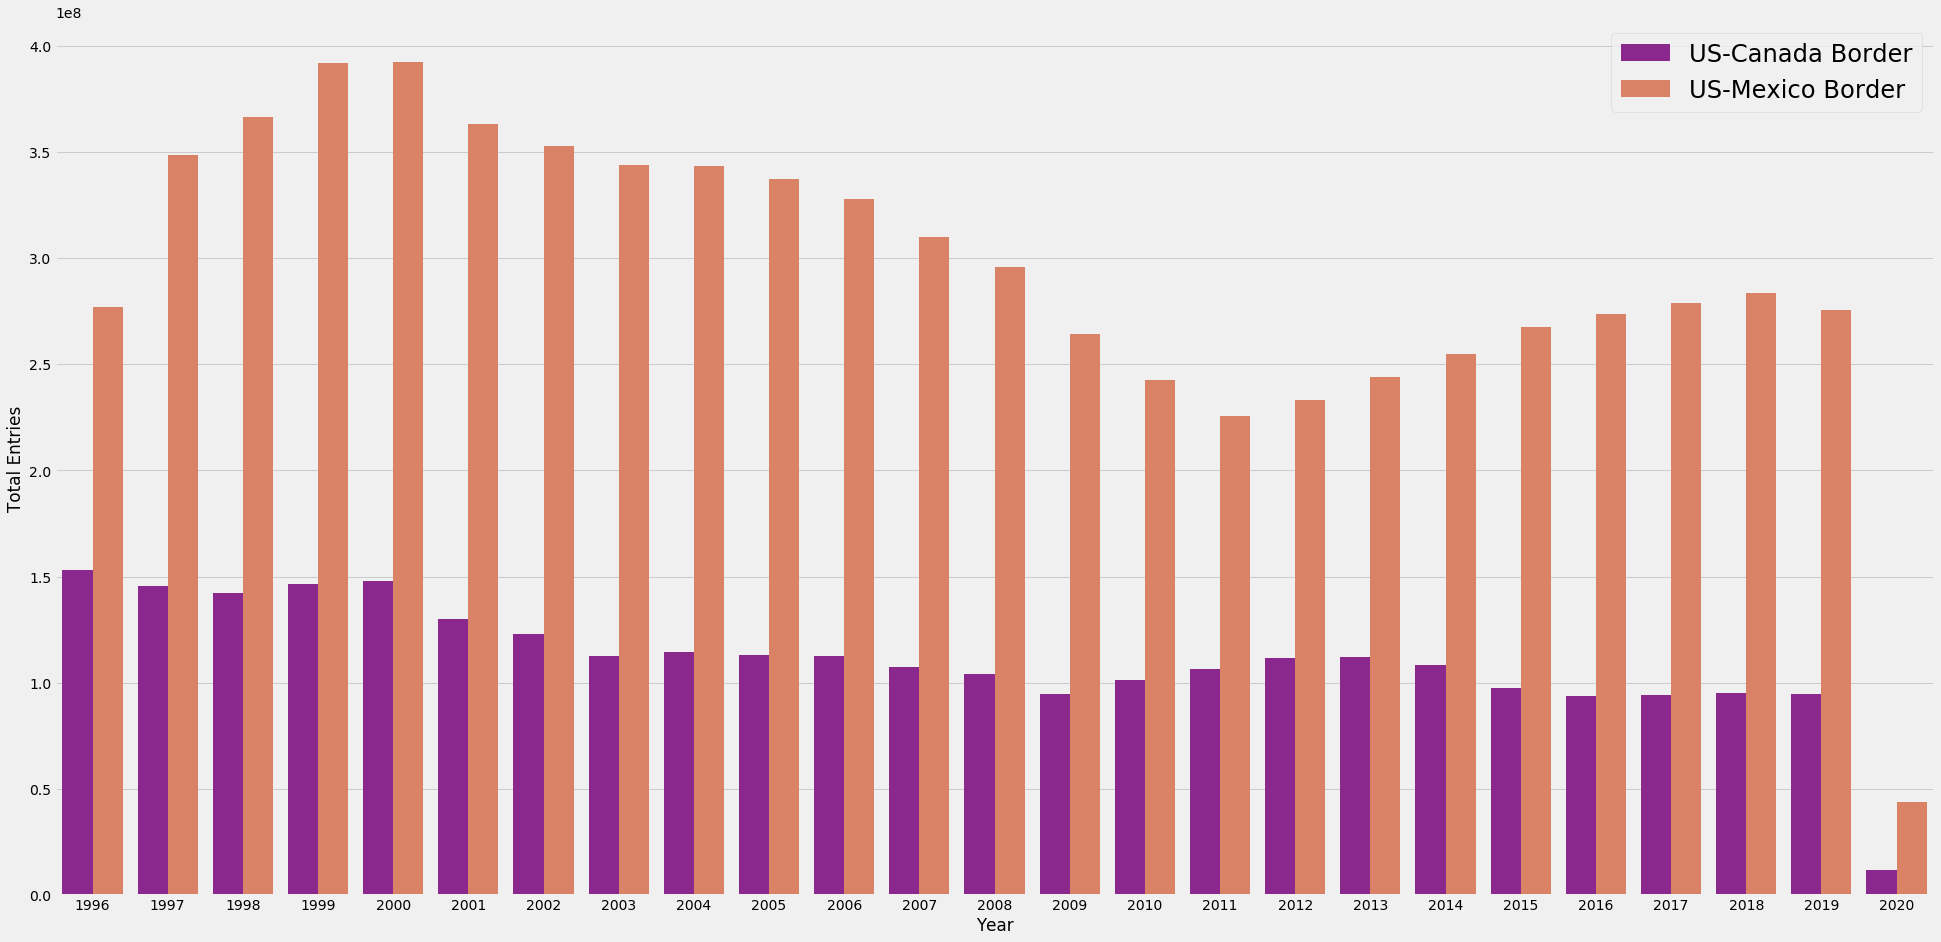

In [18]:
# Entries by year
year_data = data.groupby(['Year', 'Border'])[
    'Total Entries'].agg(['sum']).reset_index().rename(columns={'sum': 'Total Entries'})
fig = plt.subplots(figsize=(30, 15))
sns.barplot(x='Year', y='Total Entries', hue='Border',
            data=year_data, palette='plasma')
plt.legend(fontsize='xx-large')
plt.show()

# Entries by state

**When we look at the entries by U.S state we can see Texas and California are most common entry points for Mexican border, meanwhile New York and Michigan are main ports for Canadian entries.**

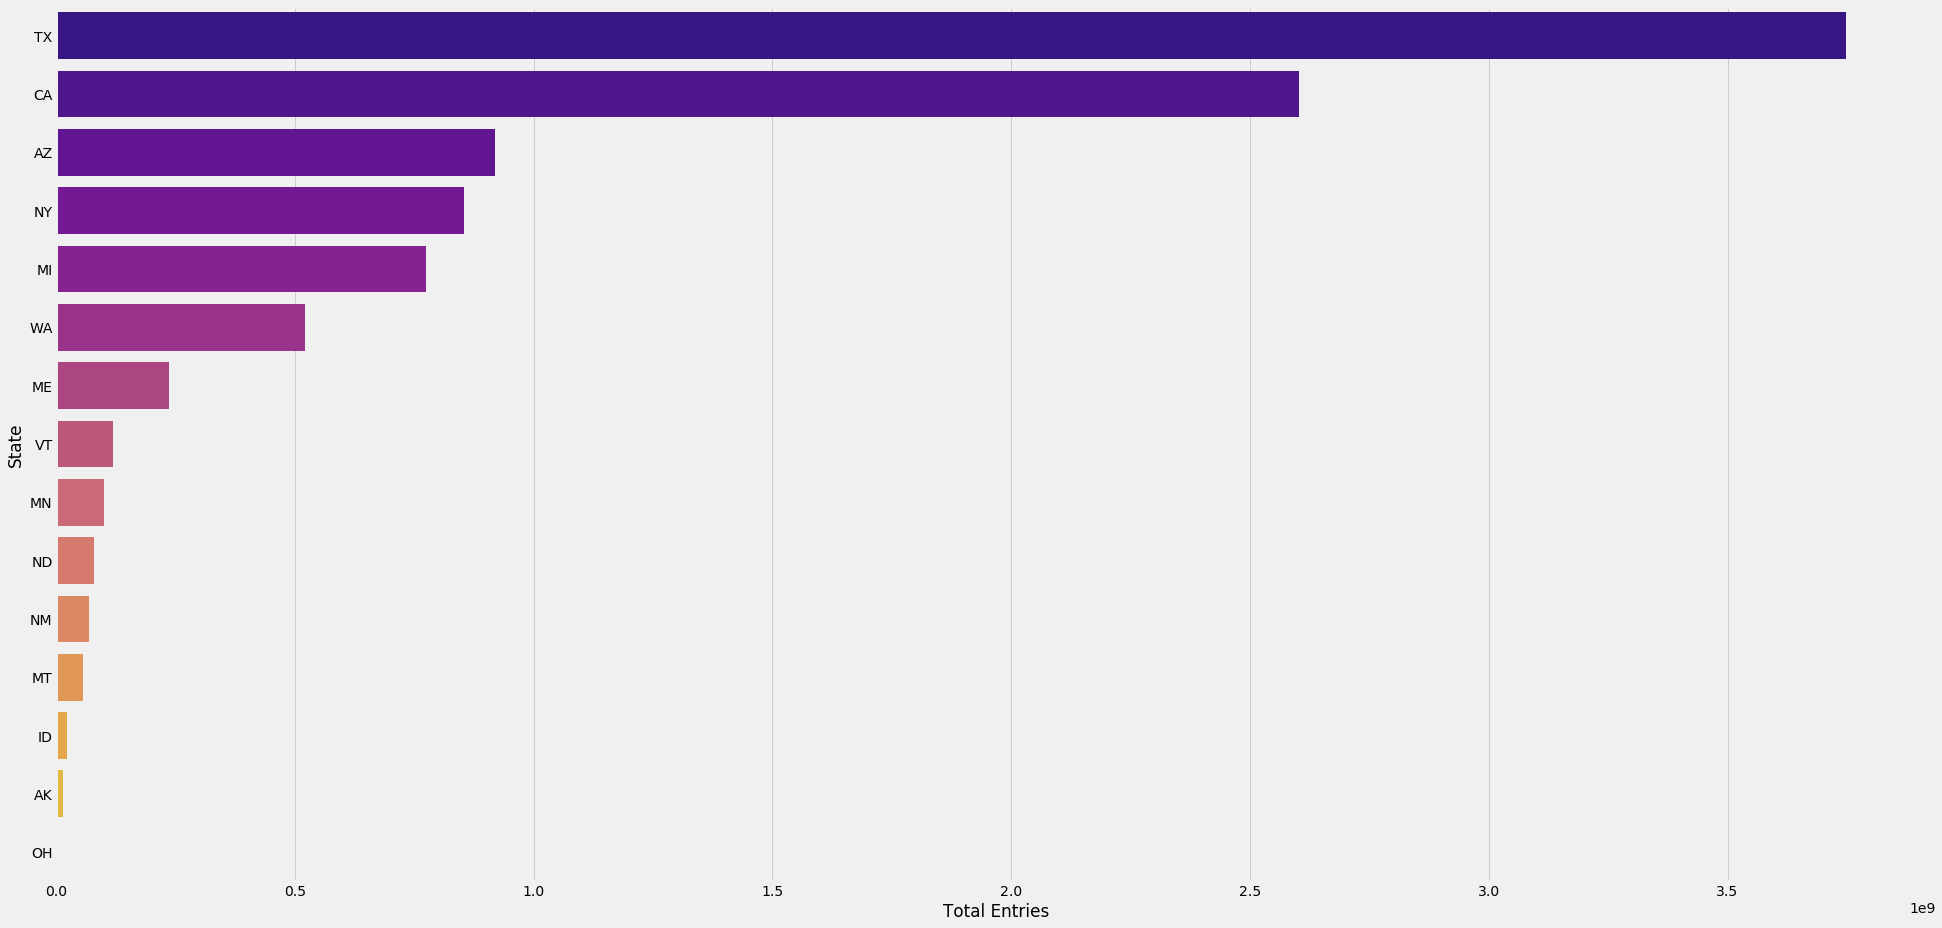

In [19]:
# Entries by state
state_data = data.groupby(['State'])['Total Entries'].agg(
    ['sum']).reset_index().sort_values('sum', ascending=False).rename(columns={'sum': 'Total Entries'})
fig = plt.subplots(figsize=(30, 15))
sns.barplot(x='Total Entries', y='State', data=state_data, palette='plasma')
plt.show()

# Entries by type

**Most common entry type for both borders are personal vehicles for both borders followed by pedestrian entries. Pedestrian entries are much more common in Mexico border. Third most common type is Trucks and that type of crossing is more common at Canadian border. We can also say that most of the trucks entering U.S from Mexico for importing purposes because they seems to enter with empty truck containers meanwhile on Canadian border it's quite opposite...**

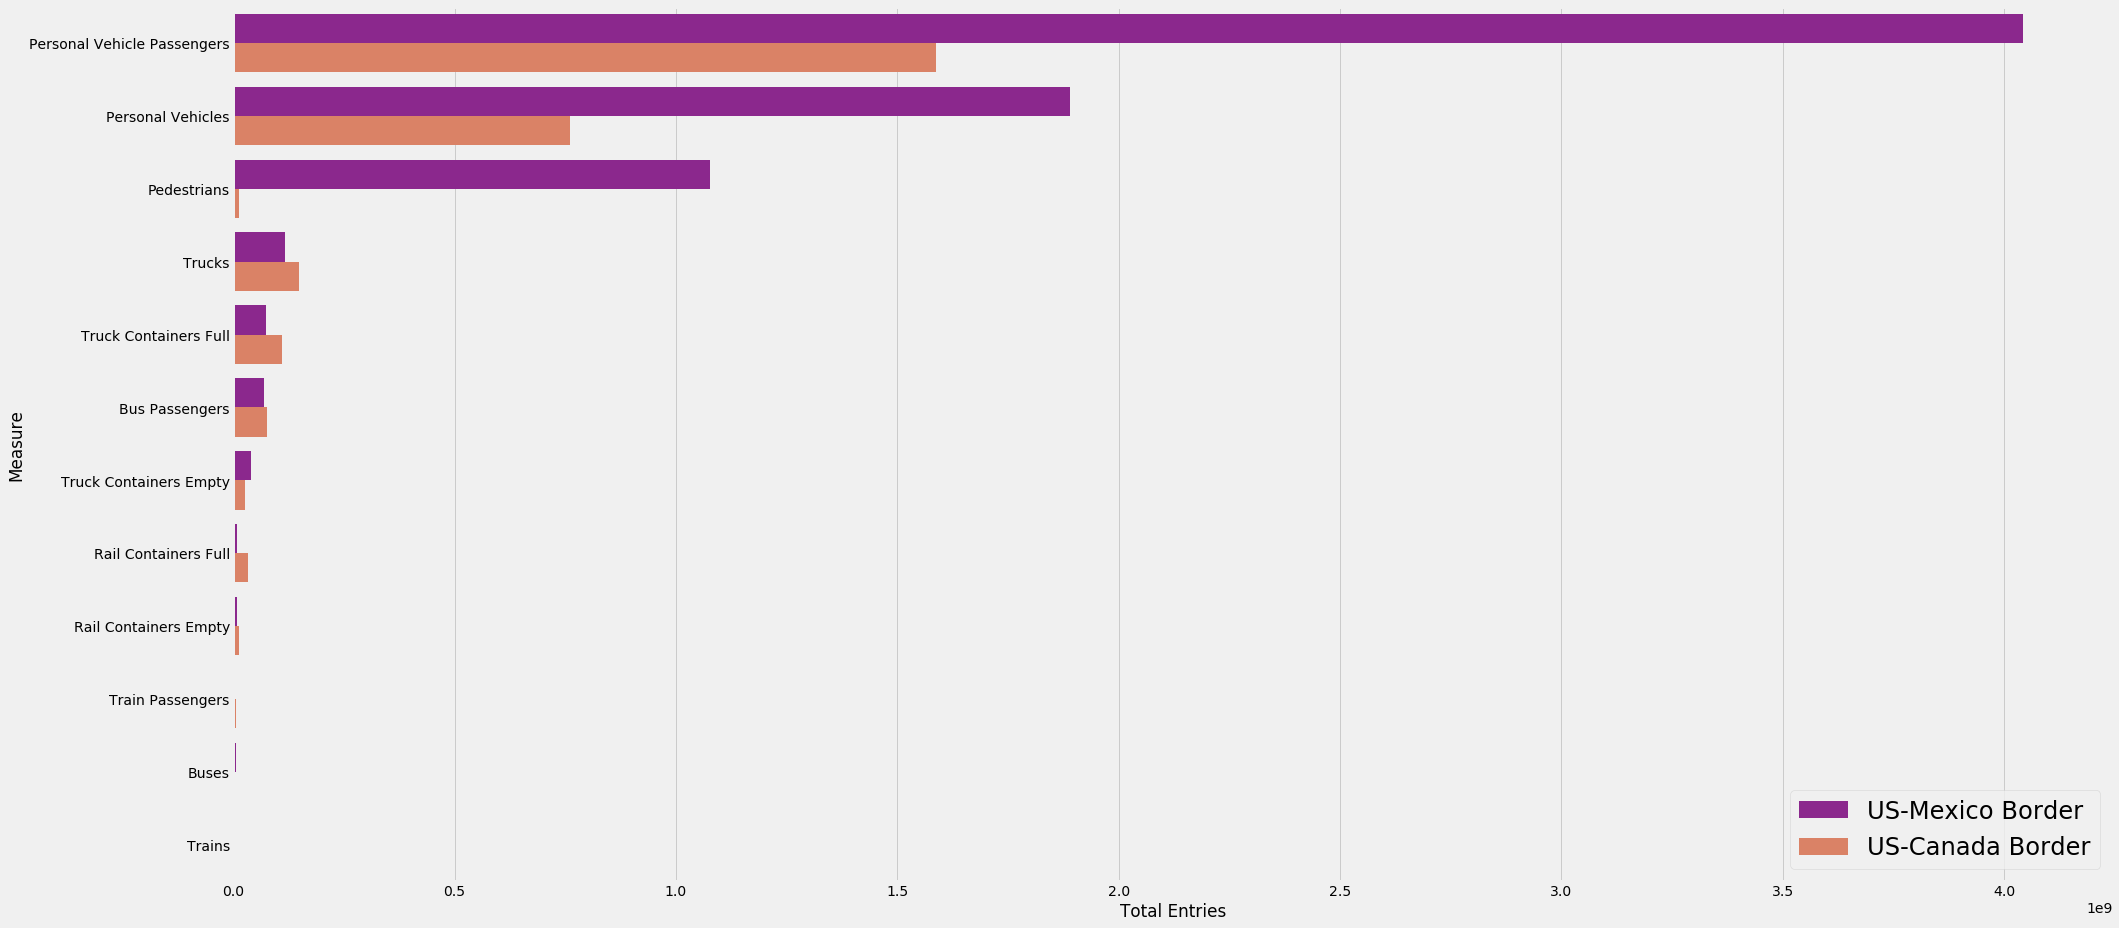

In [20]:
# Entries by measure
measure_data = data.groupby(['Border', 'Measure'])['Total Entries'].agg(
    ['sum']).reset_index().sort_values('sum', ascending=False).rename(columns={'sum': 'Total Entries'})
fig = plt.subplots(figsize=(30, 15))
sns.barplot(x='Total Entries', y='Measure', hue='Border',
            data=measure_data, palette='plasma')
plt.legend(loc='lower right', fontsize='xx-large')
plt.show()

In [21]:
data_m = data.groupby('Measure')['Total Entries'].agg(
    ['sum']).sort_values('sum', ascending=False).reset_index().rename(columns={'sum': 'Total Entries'})

data_m.head(50)

,Measure,Total Entries
0,Personal Vehicle Passengers,5629526756
1,Personal Vehicles,2651535415
2,Pedestrians,1090067964
3,Trucks,264731943
4,Truck Containers Full,185463194
5,Bus Passengers,146027374
6,Truck Containers Empty,67036035
7,Rail Containers Full,40492650
8,Rail Containers Empty,22386399
9,Buses,8754394


In [22]:
per_d = data_m.pivot_table(index=None, columns='Measure',
                           values='Total Entries').reset_index().drop('index', axis=1)

per_d['Per Bus'] = per_d['Bus Passengers'] / per_d['Buses']
per_d['Per Train'] = per_d['Train Passengers'] / per_d['Trains']
per_d['Per Car'] = per_d['Personal Vehicle Passengers'] / \
    per_d['Personal Vehicles']

# Average passenger entries per vehicle type

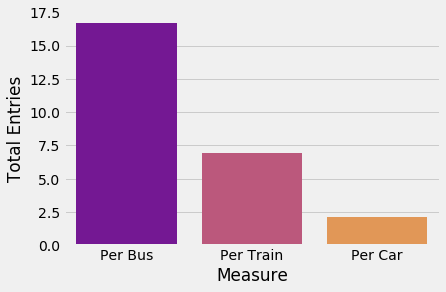

In [23]:
# Passenger entries per vehicle type
per_dc = per_d.unstack().reset_index(name='Total Entries').drop('level_1', axis=1)
sns.barplot(x='Measure', y='Total Entries', data=per_dc.loc[(per_dc['Measure'] == 'Per Bus') | (
    per_dc['Measure'] == 'Per Train') | (per_dc['Measure'] == 'Per Car')], palette='plasma')
plt.show()

# Entries by president

**When we look at the president data we can see most of the entries happened 8 years of Bush administration even with the decline in 2001-2002 followed by Obama's 8 year term. We don't have enough for Trump yet to make assumptions...**

In [24]:
# Mapping the presidents
conditions = [
    (data['Date'] <= '2001-01-20'),
    (data['Date'] >= '2001-01-20') & (data['Date'] <= '2009-01-20'),
    (data['Date'] >= '2009-01-20') & (data['Date'] <= '2017-01-20'),
    (data['Date'] >= '2017-01-20')]
choices = ['Clinton', 'Bush', 'Obama', 'Trump']
data['President'] = np.select(conditions, choices, default='None')

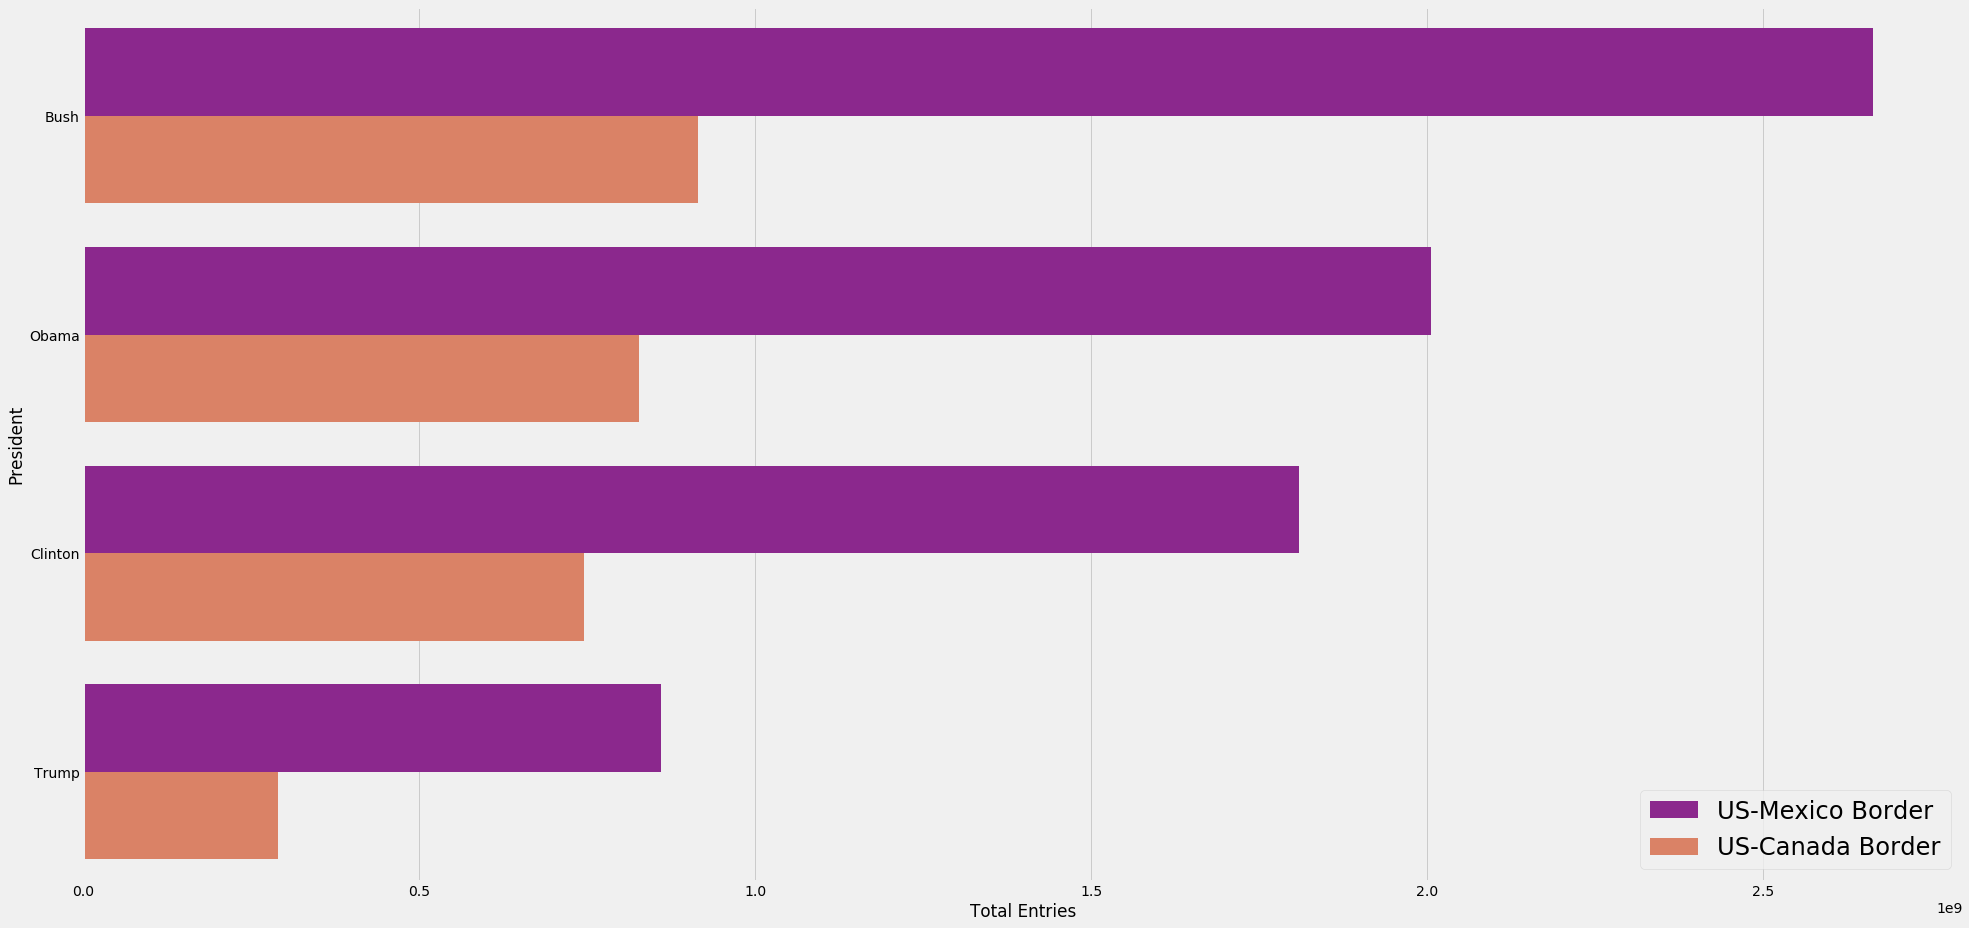

In [25]:
# Entries by president
pres_data = data.groupby(['President', 'Border'])['Total Entries'].agg(
    ['sum']).reset_index().sort_values('sum', ascending=False).rename(columns={'sum': 'Total Entries'})
fig = plt.subplots(figsize=(30, 15))
sns.barplot(x='Total Entries', y='President',
            hue='Border', data=pres_data, palette='plasma')
plt.legend(fontsize='xx-large')

# One last experimental correlation map
**I'm not sure about this graph but I just wanted to go with it and we can observe some logical correlation with some types of transporting**


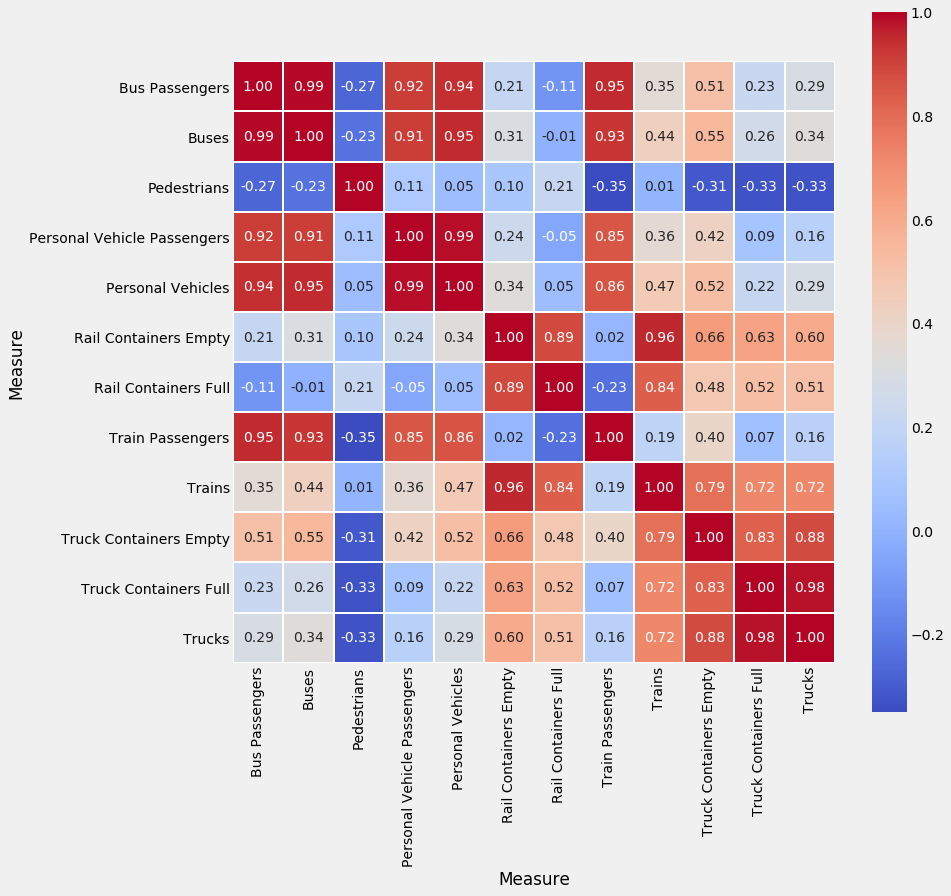

In [26]:
# Categorical correlation
msk = data[['Date', 'Measure', 'Total Entries']].set_index('Date')
month_measure = msk.pivot_table(
    'Total Entries', index=msk.index.month, columns='Measure', aggfunc='mean')


fig, axes = plt.subplots(figsize=(12, 12))
sns.heatmap(month_measure.corr(),
            annot=True,
            fmt='.2f',
            cmap='coolwarm',
            square=True,
            linewidths=1)

plt.show()

# Some last words

**I'm still a beginner and want to improve myself in every way I can. So if you have any ideas to feedback please let me know in comments, and if you liked my work please leave a like, thank you!